# Source (Danniel's github)


https://github.com/dhammack/DSB2017/blob/50ea5d169f6028b907b40276502e744c6b9d12ec/training_code/FLung_nodule_models/score_ident_model_v1.py


https://github.com/dhammack/DSB2017/blob/master/scoring_code/score_ident_model_v1_stage2.py

In [1]:
import numpy as np
import pandas as pd
from keras.models import load_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from joblib import Parallel, delayed
import sys
import scipy
import cv2
import os
from os.path import join
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
def find_start(arr, thresh=.5):
    #determine when the arr first exceeds thresh
    #arr = arr.ravel()
    for i in range(arr.shape[0]):
        if arr[i] > thresh:
            #print 'returning', i
            return np.clip(i - 8, 0, arr.shape[0])
    return 0

In [3]:
def get_strides(steps,size,offset,VOXEL_SIZE):
    if steps * VOXEL_SIZE < size - 2*offset:
        #not enough coverage. start and end are modified
        start = (size - steps*VOXEL_SIZE) / 2
        end = size - start - VOXEL_SIZE
    else:
        start = offset
        end = size-VOXEL_SIZE - offset
    return list(np.around(np.linspace(start,end,steps)).astype('int32'))

In Danniel's code, the preds are in the original scale (from 0 to 5), and he uses thresh=1.5. That means he is only keeping voxels with malignancy score higher then 1.5. 

Our CNN is giving normalized malignancy preds (from 0 to 1), if we use thresh = 1.5/5=0.3, 

In [4]:
def get_interesting_ixs(preds,thresh=0.35,max_ct=50):
    ''' 
    input the predictions, threshold, and maximum number of CT scans
    return the indices of interest
    '''
    ixs = []
    # preds_at_ixs = []
    for i in range(preds.shape[0]):
        if preds[i] > thresh:
            ixs.append(i)
            # preds_at_ixs.append(preds[i])

    if len(ixs) == 0:
        ixs = [np.argmax(preds)]
        # preds_at_ixs = [preds[np.argmax(preds)]]

    if len(ixs) > max_ct:
        ixs = np.argsort(preds)[-max_ct:]

    return np.array(ixs)

In [5]:
def img_to_vox(img,VOXEL_SIZE,mask):

    #mask == 0 -> inside lung; mask == 1 -> outside lung 

    #first let's just get the minimum amount of coverage
    samples0 = int(img.shape[0] / float(VOXEL_SIZE)) + 4
    samples1 = int(img.shape[1] / float(VOXEL_SIZE)) + 4
    samples2 = int(img.shape[2] / float(VOXEL_SIZE)) + 4

    ixs0 = get_strides(samples0,img.shape[0],0,VOXEL_SIZE)
    ixs1 = get_strides(samples1,img.shape[1],0,VOXEL_SIZE)
    ixs2 = get_strides(samples2,img.shape[2],0,VOXEL_SIZE)

    subvoxels = []
    locations = []
    centroids = []
    for i0,x0 in enumerate(ixs0):
        for i1,x1 in enumerate(ixs1):
            for i2,x2 in enumerate(ixs2):
                if mask[x0:x0+VOXEL_SIZE,x1:x1+VOXEL_SIZE,x2:x2+VOXEL_SIZE].mean() > .99:
                    #basically no lung in this voxel, might as well ignore.
                    continue
                subvoxels.append(img[x0:x0+VOXEL_SIZE,x1:x1+VOXEL_SIZE,x2:x2+VOXEL_SIZE])
                assert subvoxels[-1].shape == (VOXEL_SIZE,VOXEL_SIZE,VOXEL_SIZE), 'bad subvoxel shape ' + str(subvoxels[-1].shape) + ' ' + str([x0,x1,x2]) + ' ' + str(img.shape)
                locations.append((i0,i1,i2))
                centroids.append((x0+VOXEL_SIZE/2,x1+VOXEL_SIZE/2,x2+VOXEL_SIZE/2))
    X = np.stack(subvoxels, axis=0)
    #print 'num subvoxels:', X.shape[0]
    X = np.expand_dims(X, 1)
    #normalized locations
    #allows us to de-weight certain places...

    return X,locations,centroids

In [6]:
def crop_img(img_cpy):
    # img_raw = np.load(patient)
    # downsample = 1
    masks = []
    img_raw = img_cpy.copy()

    for i in range(img_raw.shape[2]):
        img_slice = img_raw[ :,:,i]
        img = img_slice.copy()

        img[img>-300] = 255
        img[img<-300] = 0
        img = np.uint8(img)
        _, contours, _ = cv2.findContours(img,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:


            largest_contour = max(contours, key=cv2.contourArea)
        else:
            mask = (np.zeros(img.shape, np.uint8) < 255)
            masks.append(mask)
            continue
        mask = np.zeros(img.shape, np.uint8)
        cv2.fillPoly(mask, [largest_contour], 255)

    # imshow(mask); show()

        # apply mask to threshold image to remove outside. this is our new mask
        img = ~img 
        img[(mask == 0)] = 0 # <-- Larger than threshold value

        # apply closing to the mask
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
        img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)  # <- to remove speckles...
        img = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel)
        img = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel)
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        img = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
        img = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)

        #the image has an outside part which we don't care about (value 0)
        #and a boundary that we don't care about (value 255)
        #and some noise that we don't care about (value 125)
        mask = (img < 255)
    #		 img_raw[~mask] = -2000
    #		 imshow(img_raw); colorbar(); show()
        masks.append(mask)

    #now we have one mask per slice. To determine our bounding box, take the max x,y,z plus a fuzz factor
    ixs_to_remove = [i for i,m in enumerate(masks) if np.mean(m) > .995]

    # masks =[m for m in masks if np.mean(m) < .995]
    masks = np.stack(masks, axis=2)
    masks = np.delete(masks, ixs_to_remove, axis=2)
    img_raw = np.delete(img_raw, ixs_to_remove, axis=2)


    #0 = mask, 1 = background
    x_dim = np.min(masks, axis=(1,2))
    y_dim = np.min(masks, axis=(0,2))
    z_dim = np.min(masks, axis=(0,1))

    xstart = find_start(1 - x_dim, .5)
    xend = -(find_start(1 - x_dim[::-1], .5) + 1)
    ystart = find_start(1 - y_dim, .5)
    yend = -(find_start(1 - y_dim[::-1], .5) + 1)
    zstart = find_start(1 - z_dim, .5)
    zend = -( find_start(1 - z_dim[::-1], .5) + 1)

    # try:
    assert xstart < int(img_raw.shape[0]*.5) < img_raw.shape[0] - xend, 'bad crop ' + str(xstart) + ' ' + str(xend) + ' ' + str(img_raw.shape[0])
    assert ystart < int(img_raw.shape[1]*.5) < img_raw.shape[1] - yend, 'bad crop ' + str(ystart) + ' ' + str(yend) + ' ' + str(img_raw.shape[1])
    assert zstart < int(img_raw.shape[2]*.5) < img_raw.shape[2] - zend, 'bad crop ' + str(zstart) + ' ' + str(zend) + ' ' + str(img_raw.shape[2])
    assert xend < 0 and yend < 0 and zend < 0, 'one end >= 0'
    assert xstart >= 0 and ystart >= 0 and zstart >= 0, 'one start <= 0'
    # except AssertionError as e:
        # print 'WARNING cropping failed. using full img', e
        # return img_raw

    return img_raw[xstart:xend,ystart:yend,zstart:zend], masks[xstart:xend,ystart:yend,zstart:zend]

In [8]:
def load_and_txform_file(file,model,VOXEL_SIZE,batch_size,n_TTA=32):
    #read, convert to voxels.
    xorig = np.load(os.path.join("../../data/stage1_arrays/", file))
    x = np.clip(xorig.copy(), -1000, 400)
    x,mask = crop_img(x)

    x = ((x + 1000.) / (400. + 1000.)).astype('float32')
    voxels, locs, centroids = img_to_vox(x,VOXEL_SIZE,mask)
    #predict on voxels, keep top N ROI
    preds = np.array(model.predict(voxels, batch_size=batch_size))
    topNixs = get_interesting_ixs(preds[0,:,0])
    topNvox = voxels[topNixs]
    topNcentroids = np.array(centroids)[topNixs]
    topNpreds = preds[:,topNixs,0]

    return topNvox, topNcentroids, [x.shape]*topNcentroids.shape[0], topNpreds   
#  In Danniel's code, it is returning a list of shapes: [x.shape] * topNcentroids.shape[0],
#  why don't we just keep one shape

In [9]:
PATH_MODEL = "../Models/LUNA_model_v2.h5"
model_v24 = load_model(PATH_MODEL)
PATH_RAW_ARRAY = "../../data/stage1_arrays/"
PATH_VOXELS = "../../data/stage1_TOP_voxels/"
VOXEL_SIZE = 64

/opt/anaconda/lib/python3.5/site-packages/keras/engine/topology.py:1206: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


# Unit test for one patient

In [10]:
import seaborn as sns
def unit_test(patient='337e7a428e7342d1e7f53a04247f7ad8.npy'):      
    xorig = np.load(os.path.join("../../data/stage1_arrays/", patient))
    x = np.clip(xorig.copy(), -1000, 400)
    x,mask = crop_img(x)

    x = ((x + 1000.) / (400. + 1000.)).astype('float32')
    print ("x shape: ", x.shape)
    voxels, locs, centroids = img_to_vox(x,VOXEL_SIZE,mask)
    
    print ("voxels shape:", voxels.shape)
    print ("locations:", locs[:3])
    print ("centroids:", centroids[:3])
    
    preds = np.array(model_v24.predict(x= voxels)) 
    print ("predictions (from CNN) shape: ", preds.shape)
    print ("\npred[0] shape????", preds[0].shape)
    
    # (malignancy, spiculation, lobulation, and diameter across nodules (4 features)
    print (  "min malignancy :", preds[0].min(), " max malignancy :", preds[0].max(),\
           "\nmin spiculation:", preds[1].min(), " max spiculation:", preds[1].max(),\
           "\nmin lobulation :", preds[2].min(), " max lobulation :", preds[2].max(),\
           "\nmin diameter   :", preds[3].min(), " max diameter   :", preds[3].max())
    
    topNixs = get_interesting_ixs(preds[0,:,0])
#     print ("number of top voxels", topNixs)
    
    topNvox = voxels[topNixs]
    topNcentroids = np.array(centroids)[topNixs]
#     print ("topNcentroids", topNcentroids[:5])
    
    topNpreds = preds[:,topNixs,0]
#     print ("topNpreds",topNpreds)
    
    topNpreds_malignancy = preds[0,:,0][topNixs]
#     print ("topNpreds_malignancy",topNpreds_malignancy)
    
    topNpreds_spiculation = preds[1,:,0][topNixs]
    topNpreds_lobulation = preds[2,:,0][topNixs]
    topNpreds_diameter = preds[3,:,0][topNixs]
    sns.distplot(preds[0]);

    return topNvox, topNcentroids, [x.shape] * topNcentroids.shape[0], topNpreds_malignancy

x shape:  (313, 252, 260)
voxels shape: (413, 1, 64, 64, 64)
locations: [(0, 0, 0), (0, 0, 1), (0, 0, 2)]
centroids: [(32.0, 32.0, 32.0), (32.0, 32.0, 60.0), (32.0, 32.0, 88.0)]
predictions (from CNN) shape:  (4, 413, 1)

pred[0] shape???? (413, 1)
min malignancy : 0.04064  max malignancy : 0.606117 
min spiculation: 0.00689988  max spiculation: 0.348682 
min lobulation : 0.00800679  max lobulation : 0.392116 
min diameter   : 0.00609919  max diameter   : 0.358569
number of top voxels [  7 256  10 389 154 202  43  74 357  15  58  28 354  92  66  87 148 150
 363  34  35 294 142 153 305 146  95  96 388 141 344 133 149  36  90  89
  80 155  12  93  85  94 350  32 301 143 289  82 397 147]
topNcentroids [[  32.   63.   60.]
 [ 174.  220.  116.]
 [  32.   63.  144.]
 [ 281.  126.  116.]
 [ 103.  220.   88.]]
topNpreds [[ 0.45016217  0.450921    0.45626158  0.45677713  0.45702773  0.46191454
   0.46343669  0.46883607  0.4695158   0.47629216  0.47784057  0.47879755
   0.48022056  0.4874121   0

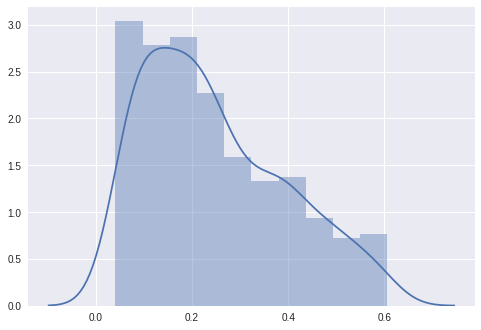

In [11]:
import time

start = time.time()
vox, cents, shapes, preds = unit_test(patient='337e7a428e7342d1e7f53a04247f7ad8.npy') 
print ("It took %0.2f second"%(time.time() - start))

x shape:  (304, 261, 286)
voxels shape: (508, 1, 64, 64, 64)
locations: [(0, 0, 0), (0, 0, 1), (0, 0, 2)]
centroids: [(32.0, 32.0, 32.0), (32.0, 32.0, 64.0), (32.0, 32.0, 95.0)]
min malignancy : 0.0516395  max malignancy : 0.690876 
min spiculation: 0.0115351  max spiculation: 0.347923 
min lobulation : 0.0113054  max lobulation : 0.39479 
min diameter   : 0.00819314  max diameter   : 0.360683
number of top voxels 50


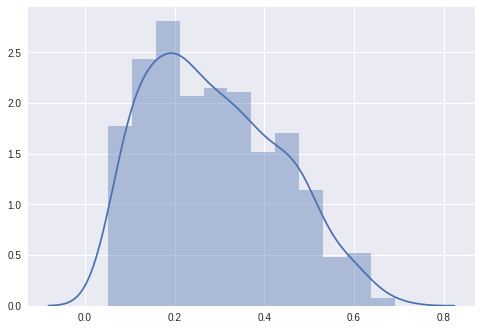

In [71]:
# This is a cancer patient
vox, cents, shapes, preds = unit_test(patient='624a34fa8fd36847724e749877343847.npy')   

x shape:  (332, 256, 316)
voxels shape: (537, 1, 64, 64, 64)
4
number of top voxels 50
50


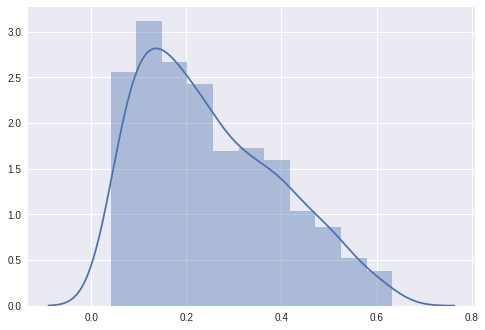

In [33]:
# This is a non-cancer patient
vox, cents, shapes, preds = unit_test(patient='eb8d5136918d6859ca3cc3abafe369ac.npy')  

# Saving the files

In [ ]:
patients = [f for f in os.listdir(PATH_RAW_ARRAY) if '.npy' in f ]
print ("patient numbers: ", len(patients) )    
for num, patient in enumerate(patients):
    if num%100 == 0:
        print ("%d patients saved"%num)
    vox, cents, shapes, preds = load_and_txform_file(patient, model_v24, VOXEL_SIZE, batch_size=32, n_TTA=2)
    np.save(join(PATH_VOXELS, 'vox_' + patient), vox)
    np.save(join(PATH_VOXELS, 'cents_' + patient), cents)
    np.save(join(PATH_VOXELS, 'shapes_' + patient), shapes)
    np.save(join(PATH_VOXELS, 'preds_' + patient), preds)

patient numbers:  1434
0 patients saved
